<a href="https://colab.research.google.com/github/shru1010/30-Days-ML-challenge/blob/main/Unet_imgSeg_OxfordIIItPet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing dependencies

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D



---


#Loading the dataset:
Click here to find the dataset: 
https://www.robots.ox.ac.uk/~vgg/data/pets/




In [22]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)



---

#Data cleaning:
* First resizing the image to(128,128)
* doing augumentation to the images
* Normalization of the images and decreasing the image mask by 1

In [87]:
def resize(input_image,input_mask):
  input_image = tf.image.resize(input_image,(128,128),method = 'nearest')
  input_mask = tf.image.resize(input_mask,(128,128),method = 'nearest')

  return input_image,input_mask

In [88]:
def augument(input_image,input_mask):
  if tf.random.uniform(()) >0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image,input_mask

In [89]:
def normalize(input_image,input_mask):
  input_image = tf.cast(input_image , tf.float32)/255
  input_mask -=1

  return input_image,input_mask


---
#Spliting training and testing images from dataset
These functions are used to preprocess the images and masks before feeding them to the UNet model for training and testing.

In [105]:

def load_image_train(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image,input_mask = resize(input_image,input_mask)
  input_image,input_mask = augument(input_image,input_mask)
  input_image,input_mask = normalize(input_image,input_mask)

  return  input_image,input_mask

In [106]:
def load_image_test(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image,input_mask = resize(input_image,input_mask)
  input_image,input_mask = normalize(input_image,input_mask)

  return  input_image,input_mask

In [107]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test,num_parallel_calls = tf.data.AUTOTUNE)

In [108]:
#defining the batch sizes and for training ,testing,validation
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

#Defining functions to be used in the U-net model

In [109]:
#convolution block,has 2 layers and uses ReLu activation and he_normal kernel initializer(used to initialize weights)
def convo_block(x, filterNo):
  x = layers.Conv2D(filterNo, 3,1,activation = "relu",padding = "same",kernel_initializer = "he_normal")(x)
  x = layers.Conv2D(filterNo, 3,1,activation = "relu",padding = "same",kernel_initializer = "he_normal")(x)
  return x

In [110]:
#the encoder or downsampling block,and returns s and p
def encoder_block(x,filterNo):
  # s is used for the skip connections for concat
  s = convo_block(x,filterNo)
  # used for the max pooling output
  p = layers.MaxPool2D(2)(s)
  return s,p

In [111]:
#decoder or upsampling block
def decoder_block(x,conv_features,filterNo):
  #transposes the input image for concatination
  x = layers.Convolution2DTranspose(filterNo,3,2,padding = "same")(x)
  #concatenates with respective s
  x = layers.concatenate([x, conv_features])
  #applies convolution block
  x = convo_block(x,filterNo)
  return x



---
#Building the U-net architecture


In [112]:
def build_unet_model():
  #input
  input = layers.Input(shape=(128,128,3))
  #downsampling or encoders,number of filters increase
  s1,p1 = encoder_block(input,64)
  s2,p2 = encoder_block(p1,128)
  s3,p3 = encoder_block(p2,256)
  s4,p4 = encoder_block(p3,512)
  #base
  base = convo_block(p4,1024)
  #upsampling or decoders,number of filters decrease
  d1 = decoder_block(base,s4,512)
  d2 = decoder_block(d1,s3,256)
  d3 = decoder_block(d2,s2,128)
  d4 = decoder_block(d3,s1,64)

  # outputs
  output = layers.Conv2D(3, 1, padding="same", activation = "softmax")(d4)

  # unet model with Keras Functional API
  unet_model = tf.keras.Model(input, output, name="U-Net")

  return unet_model


In [113]:
unet_model = build_unet_model()

In [114]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [115]:
#model fitting
NUM_EPOCHS = 5

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/5
57/57 [==============================] - 73s 1s/step - loss: 1.0655 - accuracy: 0.5868 - val_loss: 0.7698 - val_accuracy: 0.6971
Epoch 2/5
57/57 [==============================] - 57s 1s/step - loss: 0.7853 - accuracy: 0.6793 - val_loss: 0.6877 - val_accuracy: 0.7277
Epoch 3/5
57/57 [==============================] - 58s 1s/step - loss: 0.6782 - accuracy: 0.7309 - val_loss: 0.6161 - val_accuracy: 0.7544
Epoch 4/5
57/57 [==============================] - 60s 1s/step - loss: 0.5885 - accuracy: 0.7673 - val_loss: 0.5489 - val_accuracy: 0.7819
Epoch 5/5
57/57 [==============================] - 57s 1s/step - loss: 0.5269 - accuracy: 0.7913 - val_loss: 0.5068 - val_accuracy: 0.7977


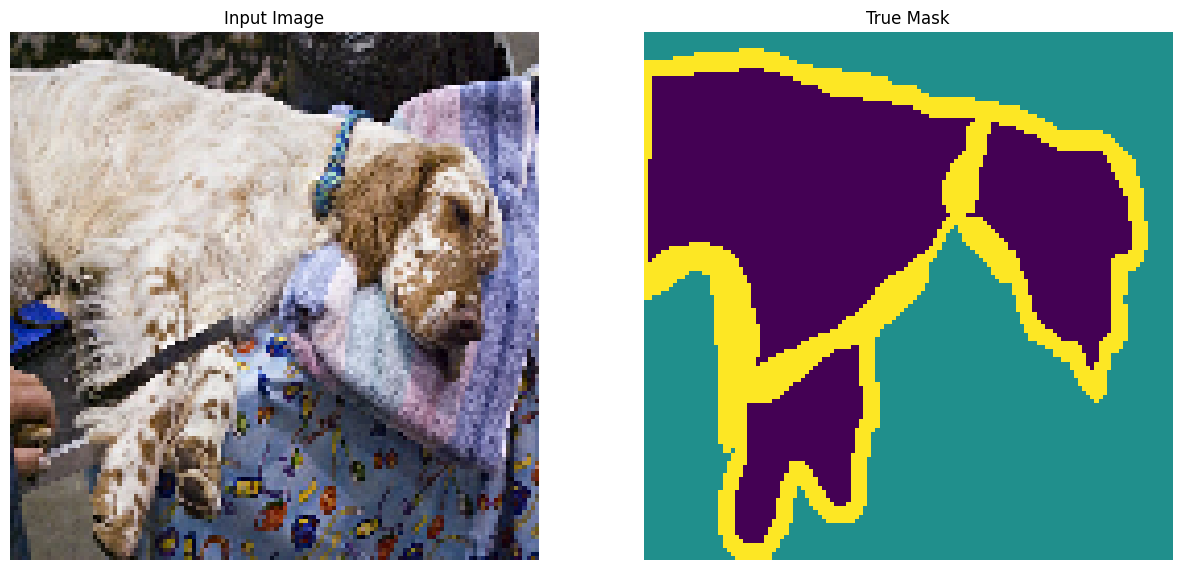

In [119]:
#function used to visualise the image and ground truth mask
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [117]:
def create_mask(pred_mask, true_mask):
    # Compute the predicted mask and convert to a numpy array
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = pred_mask[0].numpy()

    # Compute the true mask and convert to a numpy array
    true_mask = true_mask[0].numpy()

    # Compute the IoU metric between the predicted and true masks
    intersection = np.sum(np.logical_and(pred_mask, true_mask))
    union = np.sum(np.logical_or(pred_mask, true_mask))
    iou = intersection / union

    return pred_mask, iou

def show_predictions(dataset=None, num=2):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            pred_mask, iou = create_mask(pred_mask, mask)
            print("IoU accuracy:", iou*100)
            display([image[0], mask[0], pred_mask])

    else:
        pred_mask = unet_model.predict(sample_image[tf.newaxis, ...])
        pred_mask, iou = create_mask(pred_mask, sample_mask)
        print("IoU accuracy:", iou)
        display([sample_image, sample_mask, pred_mask])


2/2 [==============================] - 1s 200ms/step
IoU accuracy: 84.38494663920613


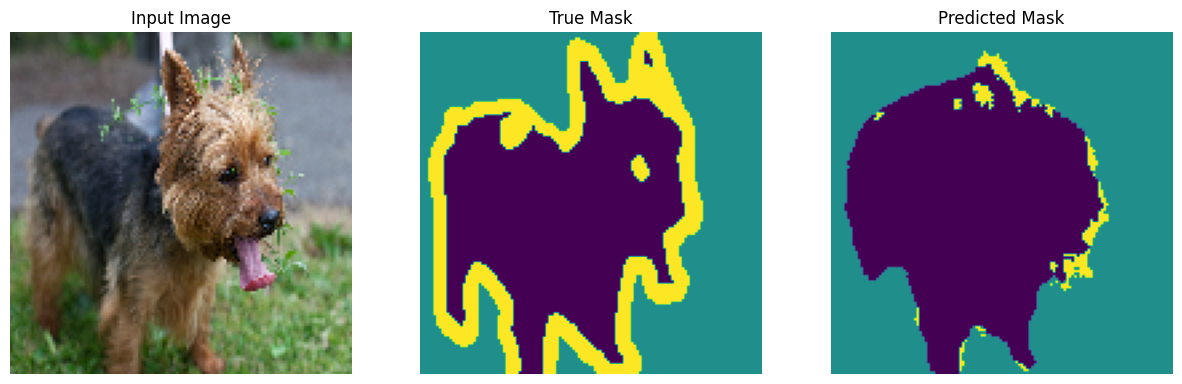

2/2 [==============================] - 0s 123ms/step
IoU accuracy: 81.20727991435395


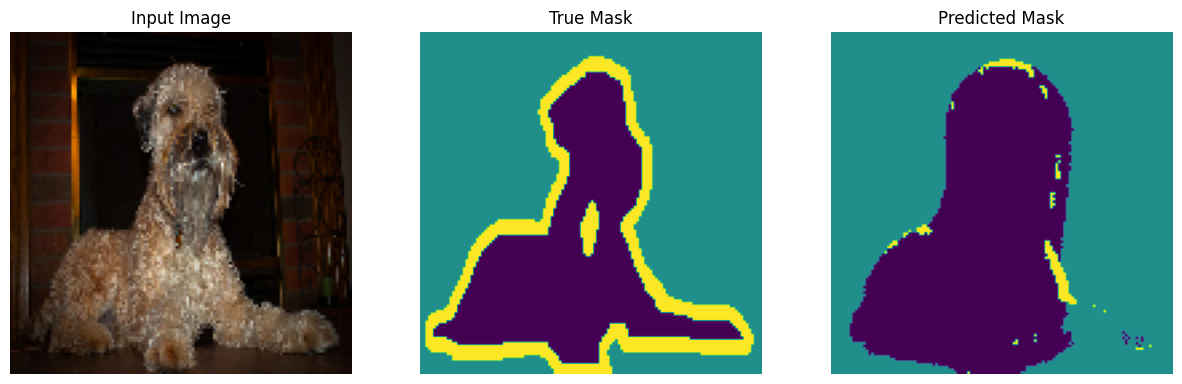

2/2 [==============================] - 0s 128ms/step
IoU accuracy: 86.9060378706681


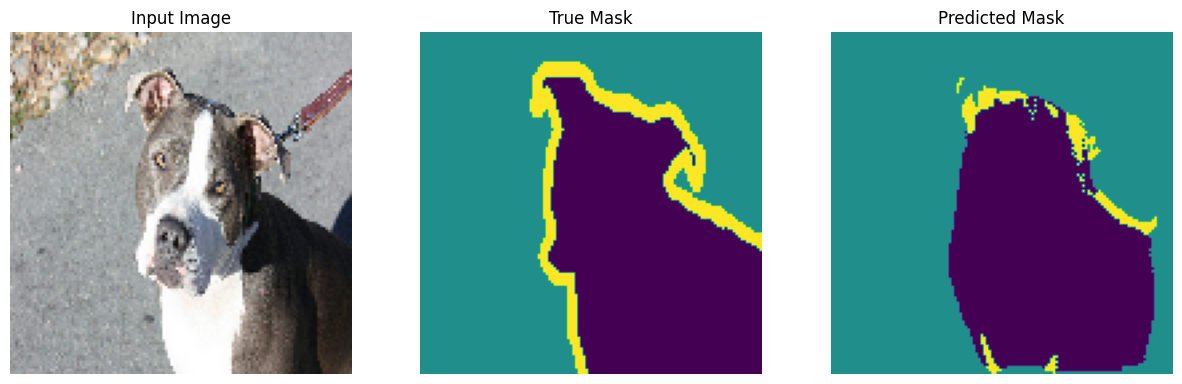

2/2 [==============================] - 0s 133ms/step
IoU accuracy: 94.48257655755016


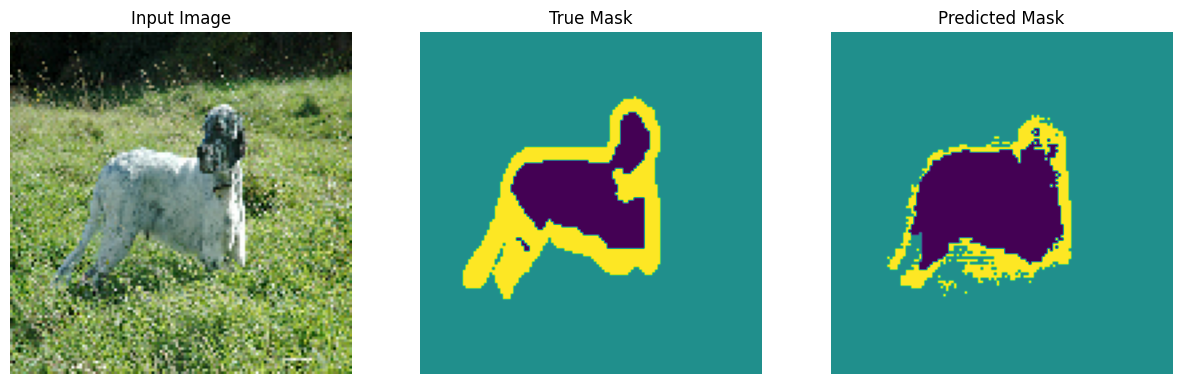

In [118]:
show_predictions(test_batches.skip(5),4)